In [1]:
import numpy as np 
import pandas as pd 
from pandas.api.types import CategoricalDtype
from sklearn import model_selection, ensemble, metrics, linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
import os

/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
base_dir = '../data'
print(os.listdir(base_dir))

['test.pkl', 'diamonds.csv', 'train.pkl']


In [3]:
df_diamonds = pd.read_csv('%s/diamonds.csv'%(base_dir), index_col='Unnamed: 0')
df_diamonds.fillna(0)
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Numeric Features 
* Carat: weight of the diamond
* depth: depth %  The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
* table: table % The width of the diamond's table expressed as a percentage of its average diameter
* price: the price of the diamond
* xlength: mm
* ywidth: mm
* zdepth: mm

In [4]:
df_diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## cut 
Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

In [5]:
cuts_ordered = ['Fair',
                'Good',
                'Very Good',
                'Premium',
                'Ideal']
df_diamonds['cut'] = df_diamonds['cut'].astype(CategoricalDtype(cuts_ordered, ordered=True))
print(df_diamonds['cut'].unique())
df_diamonds['cut'].describe()

[Ideal, Premium, Good, Very Good, Fair]
Categories (5, object): [Fair < Good < Very Good < Premium < Ideal]


count     53940
unique        5
top       Ideal
freq      21551
Name: cut, dtype: object

## color
mColor of the diamond, with D being the best and J the worst

In [6]:
colors_ordered = [  'J',
                    'I',
                    'H',
                    'G',
                    'F',
                    'E',
                    'D']
df_diamonds['color'] = df_diamonds['color'].astype(CategoricalDtype(colors_ordered, ordered=True))
print(df_diamonds['color'].unique())
df_diamonds['color'].describe()

[E, I, J, H, F, G, D]
Categories (7, object): [J < I < H < G < F < E < D]


count     53940
unique        7
top           G
freq      11292
Name: color, dtype: object

## clarity
How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

In [7]:
clarity_codes = {'I3',
'I2',
'I1',
'SI2',
'SI1',
'VS2',
'VS1',
'VVS2',
'VVS1',
'IF',
'FL'}
df_diamonds['clarity'] = df_diamonds['clarity'].astype(CategoricalDtype(clarity_codes, ordered=True))
print(df_diamonds['clarity'].unique())
df_diamonds['clarity'].describe()

[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF]
Categories (8, object): [VVS2 < VS1 < SI1 < I1 < VS2 < IF < VVS1 < SI2]


count     53940
unique        8
top         SI1
freq      13065
Name: clarity, dtype: object

## Cleaning the Data

There are some zero dimensions for the diamonds, since that must be noise or mistype, we are cleaning it.

In [8]:
from pandas.api.types import is_numeric_dtype

df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.x <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.y <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.z <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.carat <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.depth <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.table <= 0].index)

## Ref: https://gist.github.com/ariffyasri/70f1e9139da770cb8514998124560281
def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

df_diamonds = remove_outlier(df_diamonds)
df_diamonds.shape

(34307, 10)

## Handcraft features
Since the measures for the diamond follow a 3d shape, we are considering here some handcraft features. 
Volume for the diamond = reflecting its size and weight. 
Ratio between the X, Y and Z.


In [9]:
df_diamonds['volume'] = df_diamonds['x'] * df_diamonds['y'] * df_diamonds['z']
df_diamonds['ratio_xy'] = df_diamonds['x'] / df_diamonds['y']
df_diamonds['ratio_xz'] = df_diamonds['x'] / df_diamonds['z']
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,ratio_xz
61,0.35,Ideal,I,VS1,60.9,57.0,552,4.54,4.59,2.78,57.931308,0.989107,1.633094
65,0.42,Premium,I,SI2,61.5,59.0,552,4.78,4.84,2.96,68.480192,0.987603,1.614865
67,0.32,Ideal,I,VVS1,62.0,55.3,553,4.39,4.42,2.73,52.972374,0.993213,1.608059
69,0.31,Premium,G,SI1,61.8,58.0,553,4.35,4.32,2.68,50.362560,1.006944,1.623134
84,0.38,Ideal,I,SI2,61.6,56.0,554,4.65,4.67,2.87,62.323485,0.995717,1.620209
90,0.32,Premium,I,SI1,62.9,58.0,554,4.35,4.33,2.73,51.420915,1.004619,1.593407
91,0.70,Ideal,E,SI1,62.5,57.0,2757,5.70,5.72,3.57,116.396280,0.996503,1.596639
93,0.70,Ideal,G,VS2,61.6,56.0,2757,5.70,5.67,3.50,113.116500,1.005291,1.628571
94,0.71,Very Good,E,VS2,62.4,57.0,2759,5.68,5.73,3.56,115.865184,0.991274,1.595506
99,0.73,Very Good,E,SI1,61.6,59.0,2760,5.77,5.78,3.56,118.728136,0.998270,1.620787


In [10]:
cat_columns = df_diamonds.select_dtypes(['category']).columns.values
df_diamonds[cat_columns] = df_diamonds[cat_columns].apply(lambda x: x.cat.codes)

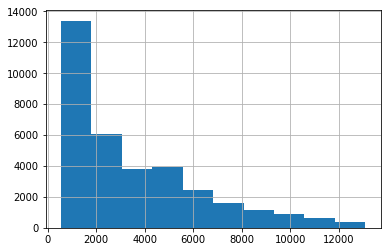

In [11]:
df_diamonds.price.hist()

In [12]:
df_diamonds.price.describe()

count    34307.000000
mean      3485.161949
std       2856.174014
min        545.000000
25%       1103.000000
50%       2499.000000
75%       5031.000000
max      13096.000000
Name: price, dtype: float64

In [13]:
train, test_reserved = model_selection.train_test_split(df_diamonds, test_size=0.2, random_state=42)
test_reserved.to_pickle("%s/test.pkl"%(base_dir))
train.to_pickle("%s/train.pkl"%(base_dir))

In [14]:
t = pd.read_pickle("%s/train.pkl"%(base_dir))

In [15]:
t.dtypes

carat       float64
cut            int8
color          int8
clarity        int8
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
volume      float64
ratio_xy    float64
ratio_xz    float64
dtype: object